# Adding external variables to models

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

## Examining the SARIMAX model

**The SARIMAX model simply adds a linear combination of exogenous variables to the
SARIMA model. This allows us to model the impact of external variables on the future
value of a time series.**

## Forecasting the real GDP using the SARIMAX model

### Exploring the exogenous variables of the US macroeconomics dataset

Let’s load the US macroeconomics dataset and explore the different exogenous variables
available to us to forecast the real GDP. This dataset is available with the statsmodels
library, meaning that you do not need to download and read an external file.
You can load the dataset using the datasets module of statsmodels.

In [1]:
import statsmodels.api as sm

macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


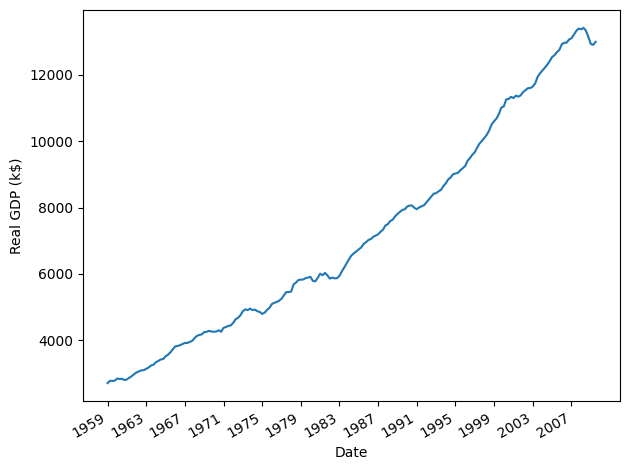

In [4]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

This displays the entire DataFrame containing the US macroeconomics dataset.
Table 9.1 describes the meaning of each variable. We have our target variable, or
endogenous variable, which is the real GDP. Then we have 11 exogenous variables
that can be used for forecasting, such as personal and federal consumption expenditures,
interest rate, inflation rate, population, and others.

- realgdp - Real gross domestic product (the target variable or endogenous variable)
- realcons - Real personal consumption expenditure
- realinv - Real gross private domestic investment
- realgovt - Real federal consumption expenditure and investment
- realdpi - Real private disposable income
- cpi - Consumer price index for the end of the quarter
- m1 - M1 nominal money stock
- tbilrate - Quarterly monthly average of the monthly 3-month treasury bill
- unemp - Unemployment rate
- pop - Total population at the end of the quarter
- infl - Inflation rate
- realint - Real interest rate

Of course, each of these variables may or may not be a good predictor of the real
GDP. **We do not have to perform feature selection because the linear model will
attribute a coefficient close to 0 for exogenous variables that are not significant in
predicting the target.**

For the sake of simplicity and clarity, we will only work with six variables in this
chapter: the real GDP, which is our target, and the next five variables listed in table as our exogenous variables.

We can visualize how each variable behaves through time to see if we can discern
any distinctive patterns.

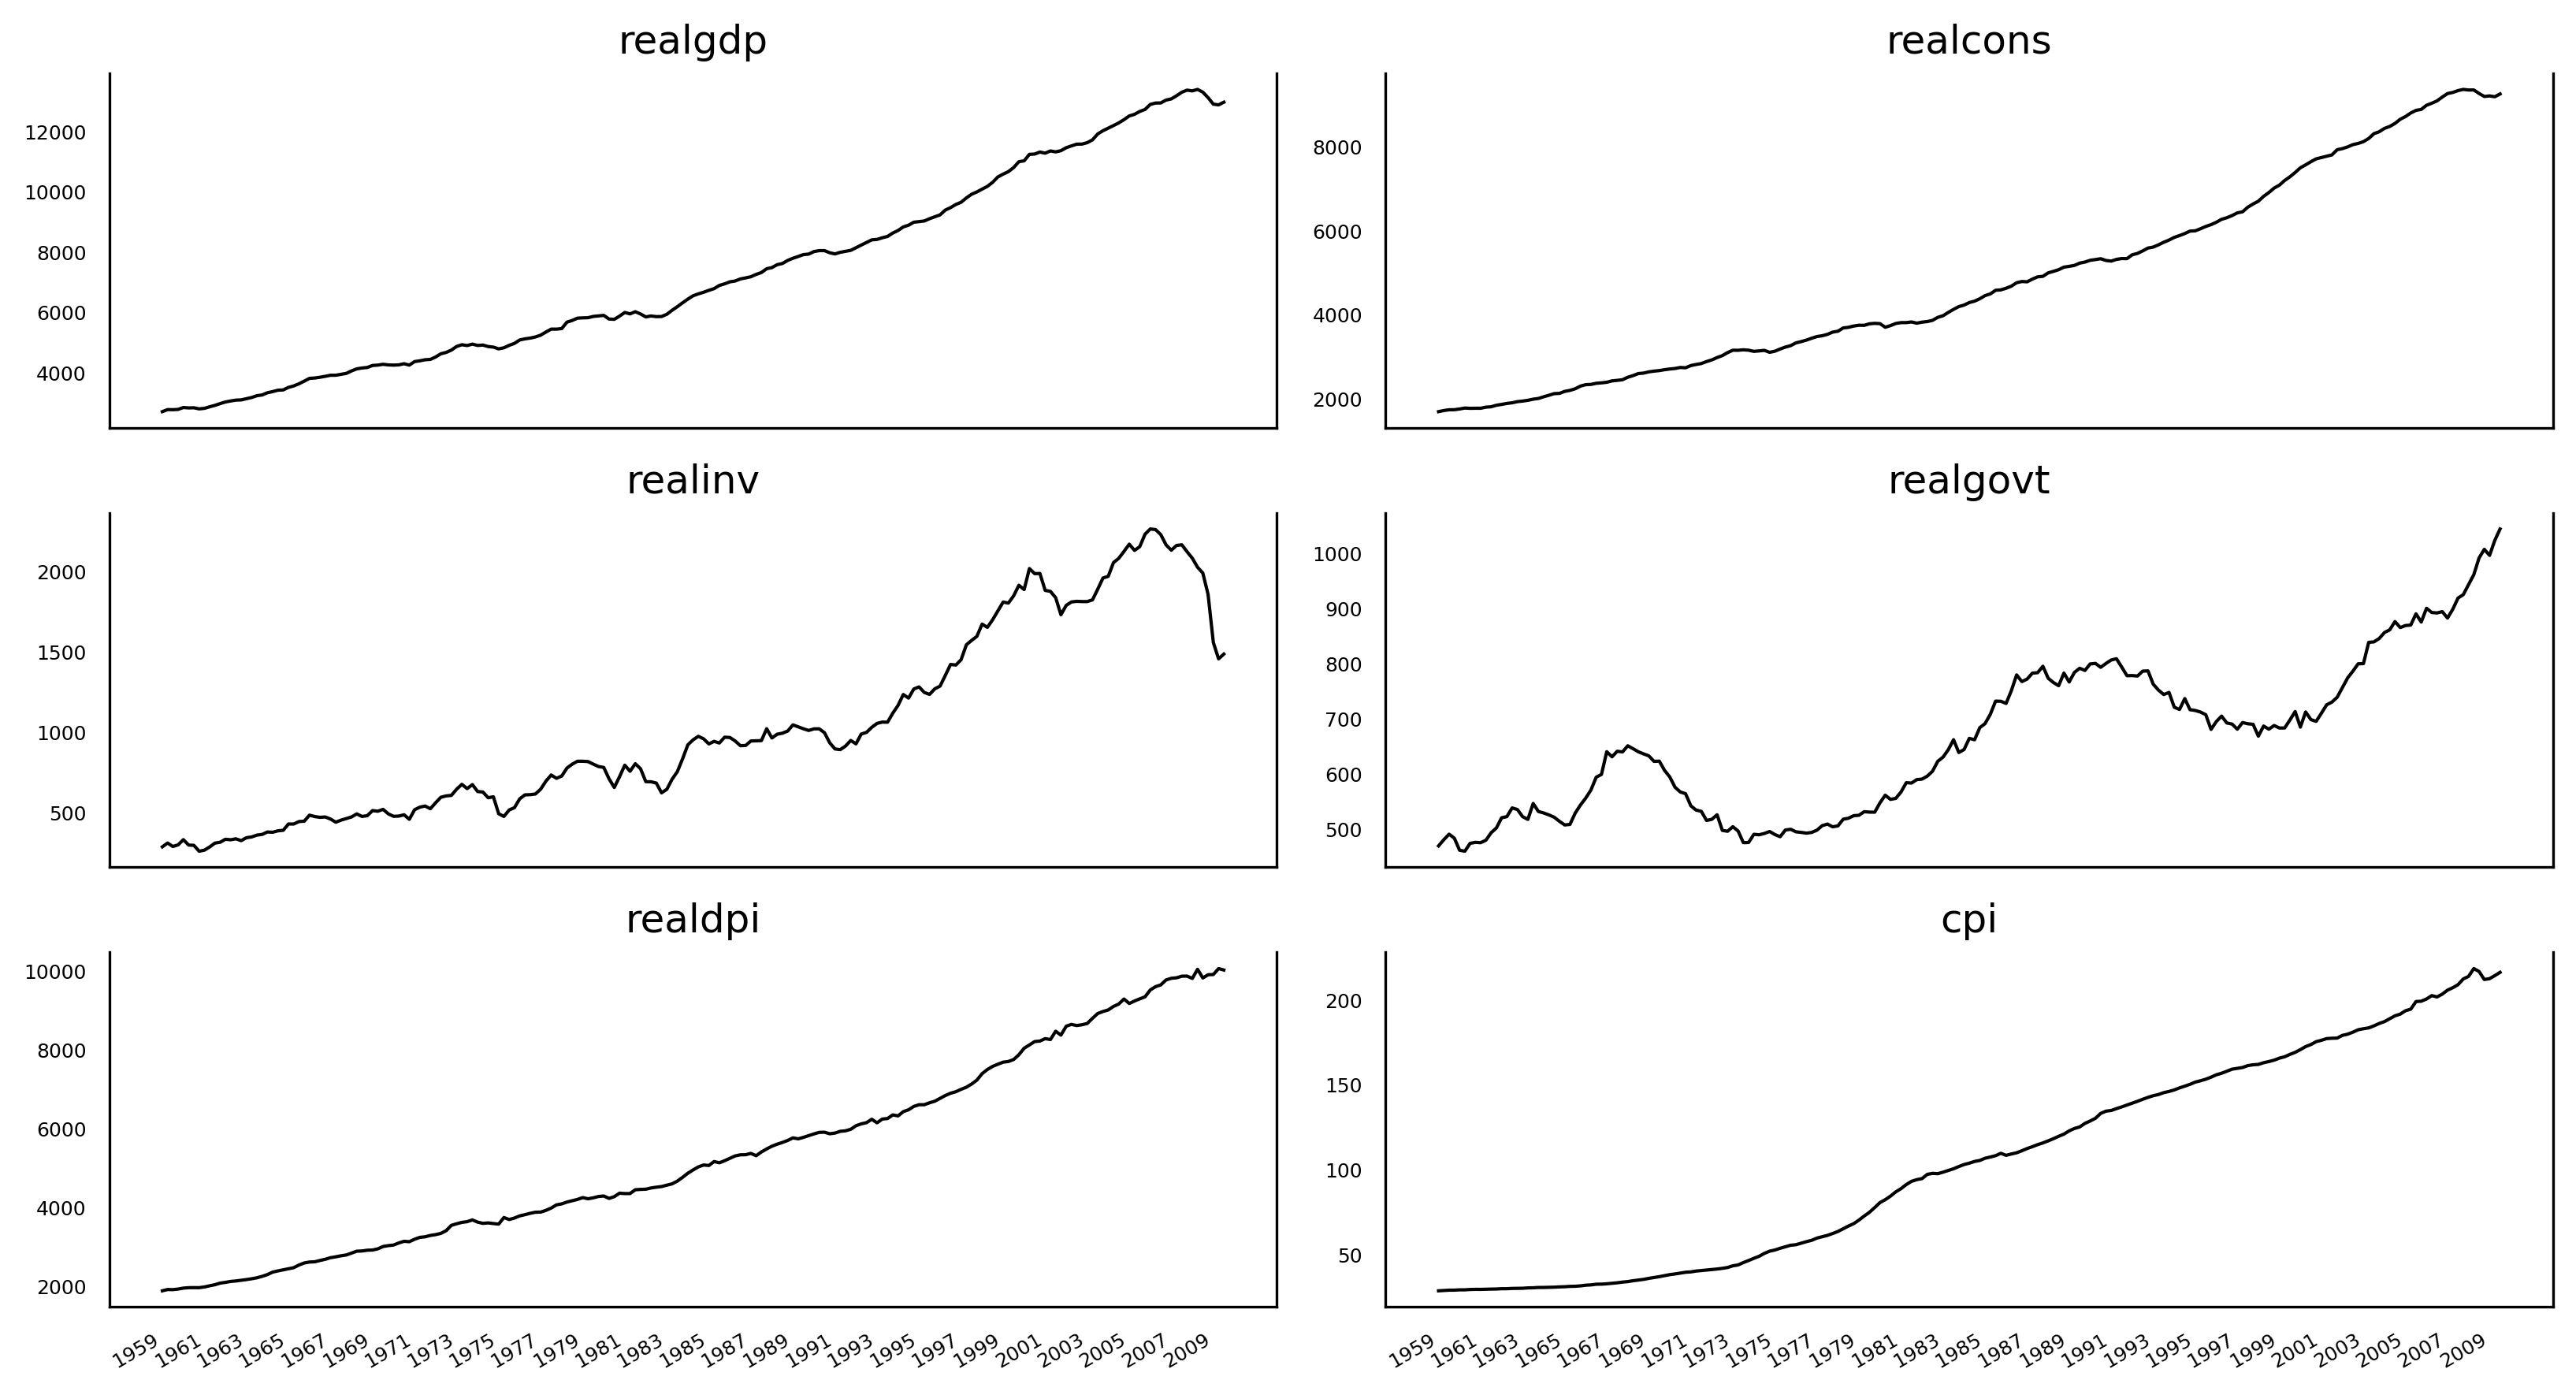

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

There are two ways to work with exogenous variables for time series forecasting. First,
we could train multiple models with various combinations of exogenous variables, and
see which model generates the best forecasts. Alternatively, we can simply include all
exogenous variables and stick to model selection using the AIC, as we know this yields
a good-fitting model that does not overfit.

### Caveat for using SARIMAX

There is an important caveat that comes with the use of the SARIMAX model. Including
external variables can potentially be beneficial, as you may find strong predictors
for your target. However, you **might encounter issues when forecasting multiple timesteps
into the future.**

Recall that the SARIMAX model uses the SARIMA(p,d,q)(P,D,Q)m model and a linear
combination of exogenous variables to predict one timestep into the future.

But what if
you wish to predict two timesteps into the future? While this is possible with a SARIMA
model, the SARIMAX model requires us to forecast the exogenous variables too.

**If your exogenous variable is easy to predict, meaning that it
follows a known function that can be accurately predicted, there is no harm in forecasting
the exogenous variable and using these forecasts to predict the target.**

In the end, there is no clear recommendation to predict only one timestep. It is
dependent on the situation and the exogenous variables available. This is where your
expertise as a data scientist and rigorous experimenting come into play. If you determine
that your exogenous variable can be accurately predicted, you can recommend
forecasting many timesteps into the future. Otherwise, your recommendation
must be to predict one timestep at a time and justify your decision by explaining that
errors will accumulate as more predictions are made, meaning that the forecasts will
lose accuracy.


### Forecasting

We are now ready to use the SARIMAX model to forecast the real GDP. Having
explored the exogenous variables of the dataset, we will incorporate them into our
forecasting model.

Before diving in, we must reintroduce the general modeling procedure. There are
no major changes to the procedure. The only modification is that we will now fit a
SARIMAX model.

We’ll first check for the stationarity of
our target using the augmented Dickey-Fuller (ADF) test.

In [6]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [7]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647164
p-value: 0.9982455372335032


This returns an ADF statistic of 1.75 and a p-value of 1.00. Since the ADF statistic is not
a large negative number, and the p-value is larger than 0.05, we cannot reject the null
hypothesis and conclude that the series is not stationary.

Therefore, we must apply a transformation and test for stationarity again. Here we
will difference the series once:

In [8]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08


This now returns an ADF statistic of –6.31 and p-value of 3.32 × 10–8. With a large negative
ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis
and conclude that the series is now stationary. Therefore, we know that d = 1. Since we
did not need to take a seasonal difference to make the series stationary, D = 0.

We will now define the optimize_SARIMAX function, which will fit all unique combinations
of the model and return a DataFrame in ascending order of AIC.

In [9]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

Next we’ll define the range of possible values for the orders p, q, P, and Q. We’ll try values
from 0 to 3, but feel free to try a different set of values. Also, since the data is collected
quarterly, m = 4.

In [10]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

To train the model, we will use the first 200 instances of both the target and exogenous
variables. We’ll then run the optimize_SARIMAX function and select the model
with the lowest AIC.

In [11]:
import warnings
warnings.filterwarnings('ignore')

target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824202
1,"(3, 3, 1, 0)",1744.961258
2,"(3, 3, 0, 1)",1744.997323
3,"(2, 2, 0, 0)",1745.438782
4,"(2, 2, 0, 1)",1746.323569
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


Once it’s completed, the function returns the verdict that the SARIMAX(3,1,3)(0,0,0)4
model is the model with the lowest AIC. Notice that the seasonal component of the
model has only orders of 0. This makes sense, as there is no visible seasonal pattern in the plot of real GDP, as shown in figure 9.4. Therefore, the seasonal component is
null, and we have an ARIMAX(3,1,3) model.

Now we can fit the selected model and display a summary table to see the coefficients
associated with our exogenous variables.

In [12]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)
print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Mon, 03 Apr 2023   AIC                           1742.824
Time:                        16:43:18   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.506      0.000       0.882       1.059
realinv        1.0132      0.033     30.694      0.000       0.948       1.078
realgovt       0.7283      0.127      5.728      0.0

You’ll notice that all exogenous variables have a p-value smaller than
0.05, except for realdpi, which has a p-value of 0.712. This means that the coefficient
of realdpi is not significantly different from 0.

However, the coefficient is kept in the model, as the p-value does not determine
the relevance of this predictor in forecasting our target.

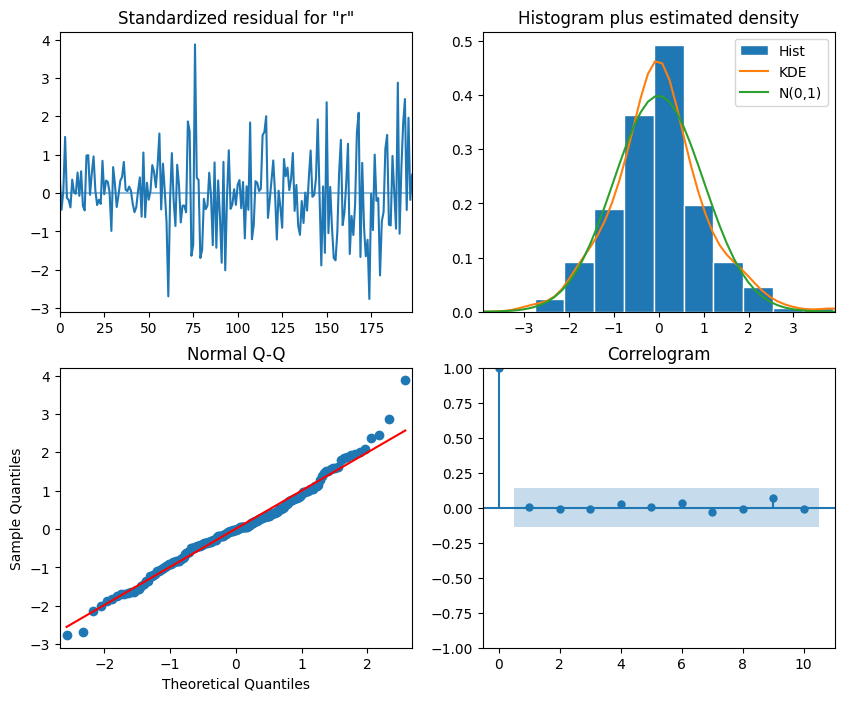

In [13]:
best_model_fit.plot_diagnostics(figsize=(10,8));

Moving on with the modeling procedure, we’ll now study the residuals of the model,
which are shown in figure 9.6. Everything points to the residuals being completely
random, just like white noise. Our model passes the visual check.

Now we’ll apply the Ljung-Box test to make sure the residuals are not correlated. We
therefore want to see p-values that are greater than 0.05, since the null hypothesis of
the Ljung-Box test is that residuals are independent and uncorrelated.

In [14]:
residuals = best_model_fit.resid

res = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(list(res["lb_pvalue"]))

[0.7615380947137302, 0.9052980751565038, 0.9774192783049646, 0.8686221040974498, 0.9392111921265458, 0.972481825973579, 0.9831041088263681, 0.9929265746973935, 0.9935041824911706, 0.9972688933125223]


All the p-values are greater than 0.05. Therefore, we do not reject the null hypothesis,
and we conclude that the residuals are independent and uncorrelated. Having passed
both residual checks, our model can be used for forecasting.

As mentioned before, the caveat of **using a SARIMAX model is that it is reasonable
to predict only the next timestep, to avoid predicting the exogenous variables as well,
which would lead us to accumulate prediction errors in the final forecast.**

Instead, to test our model, we predict the next timestep multiple times and average
the errors of each prediction. This is done using the rolling_forecast function. As a baseline model, we will use
the last known value method.

In [15]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

The recursive_forecast function allows us to predict the next timestep over a certain
period of time. Specifically, we will use it to forecast the next timestep starting in
2008 and going to the third quarter of 2009.

In [16]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064629
197,13415.266,13366.865,13373.513335
198,13324.600,13415.266,13378.820260
199,13141.920,13324.600,13327.778050
200,12925.410,13141.920,13133.237511
201,12901.504,12925.410,12887.652074
202,12990.341,12901.504,12873.794538


With the predictions done, we can visualize which model has the lowest mean absolute
percentage error (MAPE).

In [17]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7022009061821803


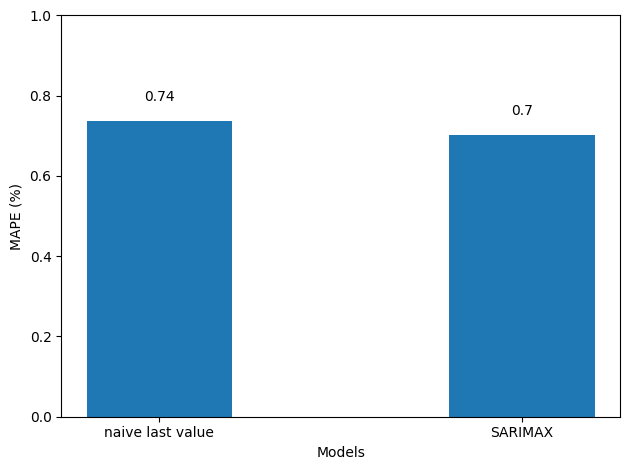

In [19]:
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

In figure 9.7 you’ll see that the SARIMAX model is the winning model by only 0.04%.
You’ll appreciate the importance of a baseline here, as both methods achieve an
extremely low MAPE, showing that the SARIMAX model is only slightly better than
simply predicting the last value. This is where the business context comes into play. In
our case, since we are predicting the real GDP of the United States, a difference of
0.04% represents thousands of dollars. This difference might be relevant in this particular
context, justifying the use of the SARIMAX model, even though it is only
slightly better than the baseline.

## Summary

Those models **work particularly well when you have small
datasets (usually less than 10,000 data points)**, and when the **seasonal period is
monthly, quarterly, or yearly**. 

In situations where you have daily seasonality or where
the dataset is very large (more than 10,000 data points), those statistical models
become very slow, and their performance degrades.

Thus, we turn to deep learning. Deep learning is a subset of machine learning
that focuses on building models on the neural network architecture. Deep learning
has the advantage that it tends to perform better as more data is available, making
it a great choice for forecasting high-dimensional time series.

Deep learning shines when we have large complex datasets. In those situations, deep
learning can leverage all the available data to infer relationships between each feature
and the target, usually resulting in good forecasts.

In the context of time series, a dataset is considered to be large when we have
more than 10,000 data points. Of course, this is an approximation rather than a hardset
limit, so if you have 8,000 data points, deep learning could be a viable option.
When the size of the dataset is large, any declination of the SARIMAX model will take
a long time to fit, which is not ideal for model selection, as we usually fit many models
during that step.

**If your data has multiple seasonal periods, the SARIMAX model cannot be used.**
For example, suppose you must forecast the hourly temperature. It is reasonable to
assume that there will be daily seasonality, as temperature tends to be lower at night
and higher during the day, but there is also yearly seasonality, due to temperatures
being lower in winter and higher during summer. In such a case, deep learning can be
used to leverage the information from both seasonal periods to make forecasts. In
fact, from experience, fitting a SARIMA model in such a case will usually result in
residuals that are not normally distributed and still correlated, meaning that the
model cannot be used at all.

Ultimately, **deep learning is used either when statistical models take too much time
to fit or when they result in correlated residuals that do not approximate white noise.**
This can be due to the fact that there is another seasonal period that cannot be considered
in the model, or simply because there is a nonlinear relationship between the
features and the target. In those cases, deep learning models can be used to capture this
nonlinear relationship, and they have the added **advantage of being very fast to train.**